## Data Understanding
***
This dataset, [from kaggle](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset), is a cleaned version of the responses from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html)

In [1]:
# Import standard packages
import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [2]:
# Loading the datasets.
df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')
print(df.shape)
df.head()

(308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


As you can see, we have 308,854 rows, each with 18 feature columns and 1 target column:

* `General_Health`: Respondent's reported general health
* `Checkup`: Time since respondent's last routine checkup
* `Exercise`: Participation in any physical activities or exercises in the past month
* `Heart_Disease`: Respondents that reported having coronary heart disease or myocardial infarction
* `Skin_Cancer`: Respondents that reported having skin cancer
* `Other_Cancer`: Respondents that reported having any other types of cancer
* `Depression`: Respondents that reported having a depressive disorder
* `Diabetes`: Respondents that reported having a diabetes
* `Arthritis`: Respondents that reported having an Arthritis
* `Sex`: Respondent's Gender
* `Age_Category`: Respondent's Age, by category
* `Height_(cm)`: Respondent's Height in centimeters
* `Weight_(kg)`: Respondent's Weight in kilograms
* `BMI`: Body Mass Index
* `Smoking_History`: Respondents that reported having a history of smoking cigarettes
* `Alcohol_Consumption`: Number of days, in the past 30 days, where respondent has had at least one alcoholic beverage
* `Fruit_Consumption`: Number of servings of fruit during the past 30 days
* `Green_Vegetables_Consumption`: Number of servings of vegetables during the past 30 days
* `FriedPotato_Consumption`: Number of servings of fruit during the past 30 days

In [3]:
# There are no missing values. 
# There are 12 features which are object types, 
# we will need to convert these to numeric types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

This data set includes 12 categorical variables (including the target `Heart_Disease`) and 7 numeric variables.

In [4]:
categorical = list(df.select_dtypes(object).columns)
for i in categorical:
    print(i)
    print(df[i].value_counts())
    print('----------\n')

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: General_Health, dtype: int64
----------

Checkup
Within the past year       239371
Within the past 2 years     37213
Within the past 5 years     17442
5 or more years ago         13421
Never                        1407
Name: Checkup, dtype: int64
----------

Exercise
Yes    239381
No      69473
Name: Exercise, dtype: int64
----------

Heart_Disease
No     283883
Yes     24971
Name: Heart_Disease, dtype: int64
----------

Skin_Cancer
No     278860
Yes     29994
Name: Skin_Cancer, dtype: int64
----------

Other_Cancer
No     278976
Yes     29878
Name: Other_Cancer, dtype: int64
----------

Depression
No     246953
Yes     61901
Name: Depression, dtype: int64
----------

Diabetes
No                                            259141
Yes                                            40171
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during p

Of our 12 categorical variables:
* There are 8 variables that have no order to them and will need to be OneHotEncoded.
* There are 3 ordinal variables, that is, categories which have an order. These include `General_Health`, `Checkup`, and `Age_Category`.

In [5]:
# Identifying ordinal variables and removing them from categorical
ordinal = ['General_Health', 'Checkup', 'Age_Category']
for i in ordinal:
    categorical.remove(i)
categorical.remove('Heart_Disease')

In [6]:
# These numeric variables are scaled differently and will need to be 
# normalized before including them in specific models

# Max and min values seem reasonable given context. 

numeric = list(df.select_dtypes(exclude=object).columns)
df[numeric].describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


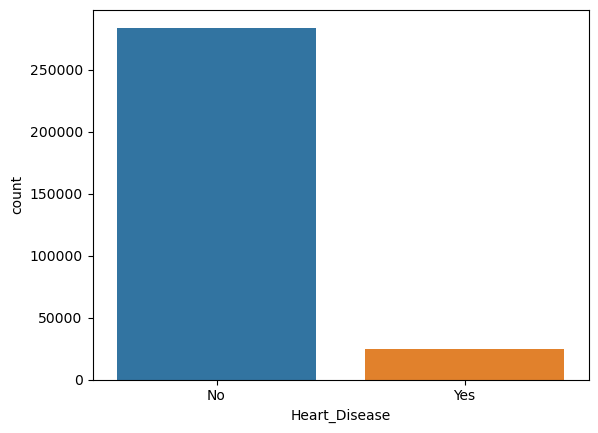

In [7]:
# Our target variable is very imbalanced.
g = sns.countplot(data = df, x= "Heart_Disease")
plt.show();

Exercise


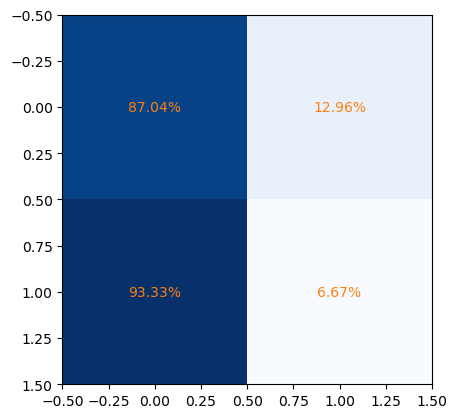

----------

Skin_Cancer


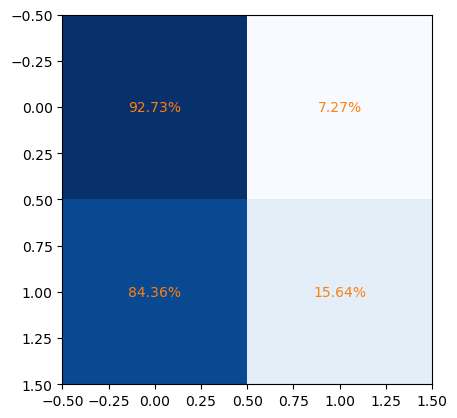

----------

Other_Cancer


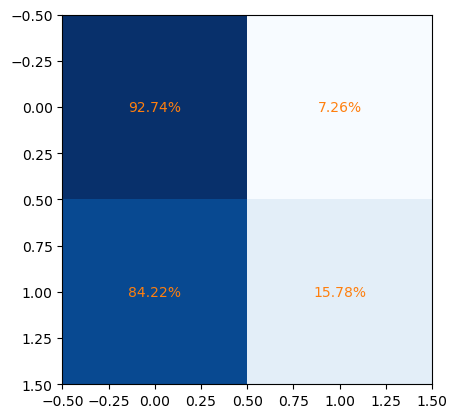

----------

Depression


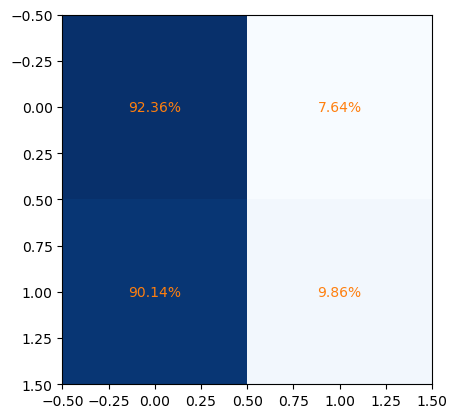

----------

Diabetes


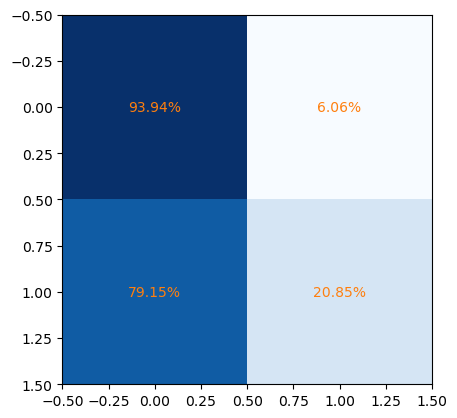

----------

Arthritis


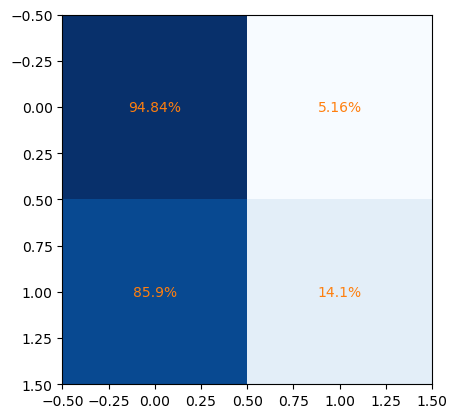

----------

Sex


C:\Users\ronlo\AppData\Local\Temp\ipykernel_16700\3031968864.py:3: RuntimeWarning: invalid value encountered in scalar divide
  nn = ((df[i]=='No') & (df['Heart_Disease']=='No')).sum()/(df[i]=='No').sum()
C:\Users\ronlo\AppData\Local\Temp\ipykernel_16700\3031968864.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ny = ((df[i]=='No') & (df['Heart_Disease']=='Yes')).sum()/(df[i]=='No').sum()
C:\Users\ronlo\AppData\Local\Temp\ipykernel_16700\3031968864.py:5: RuntimeWarning: invalid value encountered in scalar divide
  yn = ((df[i]=='Yes') & (df['Heart_Disease']=='No')).sum()/(df[i]=='Yes').sum()
C:\Users\ronlo\AppData\Local\Temp\ipykernel_16700\3031968864.py:6: RuntimeWarning: invalid value encountered in scalar divide
  yy = ((df[i]=='Yes') & (df['Heart_Disease']=='Yes')).sum()/(df[i]=='Yes').sum()


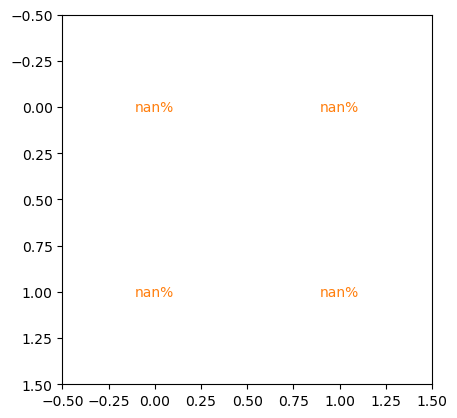

----------

Smoking_History


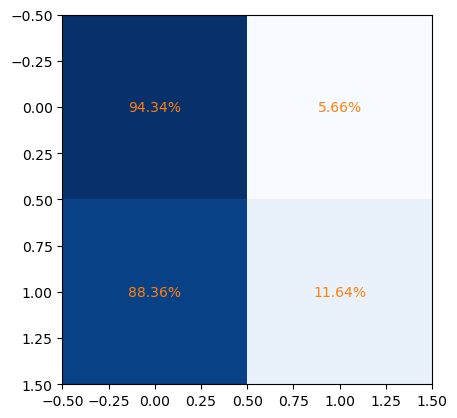

----------



In [8]:
for i in categorical:
    print(i)
    nn = ((df[i]=='No') & (df['Heart_Disease']=='No')).sum()/(df[i]=='No').sum()
    ny = ((df[i]=='No') & (df['Heart_Disease']=='Yes')).sum()/(df[i]=='No').sum()
    yn = ((df[i]=='Yes') & (df['Heart_Disease']=='No')).sum()/(df[i]=='Yes').sum()
    yy = ((df[i]=='Yes') & (df['Heart_Disease']=='Yes')).sum()/(df[i]=='Yes').sum()
    num = [nn, yn, ny, yy]

    fig, ax = plt.subplots()
    im = ax.imshow([[nn, ny],[yn,yy]],cmap='Blues')
    for i,j in enumerate(num):
        text = str(round(j*100,2))+'%'
        ax.text(i//2, i%2, text,ha="center", va="center", color="tab:orange")
    plt.show();
    print('----------')
    print('')

(Insert some visual about the data)